# Session 9: Logistic Regression <img src="diagrams/horse-racetrack-copy.jpg" align="right" alt="Source: https://www.raceadvisor.co.uk/wp-content/uploads/2014/09/horse-racetrack-copy.jpg" style="width:550px;"/>

## *Stay Linear while Powerful*


### Haiping Lu -  COM4509/6509 MLAI2018 

### Based on slides by Neil D. Lawrence

## Overview
### Session 8 - Naive Bayes

* Naive Bayes classifier
* Numerical issues due to multiplication of probabilities: use **log**, use [Laplace smoothing](https://en.wikipedia.org/wiki/Additive_smoothing) (also in Session 8 notebook, search keywords).

### This session
* Logistic regression: direct estimation of the probability for each class. Note: a **classification** rather than regression algorithm.
* Why stay *linear*: scalability (speed), interpretation, model complexity
* Two **default** linear classifier in Matlab: logistic regression (LR) and linear SVM
* For your possible interest only: [Watch: Conditional Logistic Regression Applied to Predicting Horse Race Winners in Hong Kong](https://www.youtube.com/watch?v=5gW0PO7g6pY)
* For your possible interest only: [Kaggle Competition: Hong Kong Horse Racing Results 2014-17 Seasons](https://www.kaggle.com/lantanacamara/hong-kong-horse-racing) with notebook, code, data, discussions. Happy exploring!
* Many examples (with notebooks) at [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)


In [8]:
import numpy as np
import pandas as pd
import pods
import matplotlib.pyplot as plt
%matplotlib inline

## Logistic Regression  

### Log Odds

* Model the *log-odds* with the basis functions.
* [odds](http://en.wikipedia.org/wiki/Odds) are defined as the ratio of the probability of a positive outcome, to the probability of a negative outcome. 
* Probability is between zero and one, odds are:
    $$ \frac{\pi}{1-\pi} $$
* Odds are between $0$ and $\infty$. 
* Logarithm of odds maps them to $-\infty$ to $\infty$.<img src="diagrams/log1.png" align="middle" alt="Source: http://portal.tpu.ru:7777/SHARED/k/KONVAL/Sites/English_sites/Site3_M/img/log1.png" style="width:150px;"/>

### Logit Link Function

* The [Logit function](http://en.wikipedia.org/wiki/Logit), $$g^{-1}(\pi_i) = \log\frac{\pi_i}{1-\pi_i}.$$ This function is known as a *link function*. $i$ is the data point index.

* For a standard regression we take,
    $$f(\mathbf{x}_i) = \mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}_i),$$
* For classification we perform a logistic regression. 
    $$\log \frac{\pi_i}{1-\pi_i} = \mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}_i)$$

### Inverse Link Function

We have defined the link function as taking the form $g^{-1}(\cdot)$ implying that the inverse link function is given by $g(\cdot)$. Since we have defined,
$$
g^{-1}(\pi(\mathbf{x})) = \mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})
$$
we can write $\pi$ in terms of the *inverse link* function, $g(\cdot)$ as 
$$
\pi(\mathbf{x}) = g(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})).
$$

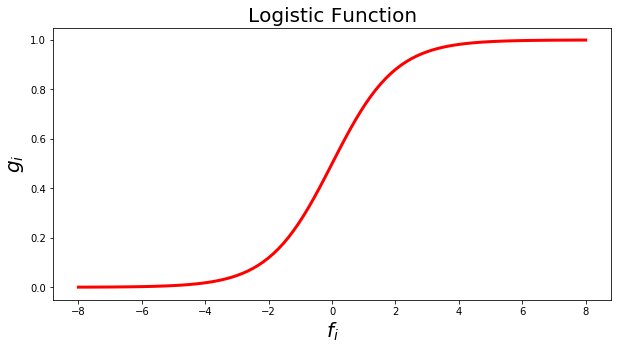

In [9]:
fig, ax = plt.subplots(figsize=(10,5))
f = np.linspace(-8, 8, 100)
g = 1/(1+np.exp(-f))

ax.plot(f, g, 'r-', linewidth=3)
ax.set_title('Logistic Function', fontsize=20)
ax.set_xlabel('$f_i$', fontsize=20)
ax.set_ylabel('$g_i$', fontsize=20)
plt.savefig('./diagrams/logistic.svg')

### Logistic function

* [Logistic](http://en.wikipedia.org/wiki/Logistic_function) (or sigmoid) squashes real line to between 0   & 1. Sometimes also called a 'squashing function'. 
![](./diagrams/logistic.svg)


### Prediction Function
* Can now write $\pi$ as a function of the input and the parameter vector as, $$\pi(\mathbf{x},\mathbf{w}) = \frac{1}{1+ \exp\left(-\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})\right)}.$$

* Compute the output of a standard linear basis function composition ($\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})$, as we did for linear regression)

* Apply the inverse link function, $g(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}))$. 

* Use this value in a Bernoulli distribution to form the likelihood. 

### Bernoulli Reminder

* From last time $$P(y_i|\mathbf{w}, \mathbf{x}) = \pi_i^{y_i} (1-\pi_i)^{1-y_i}$$

* Trick for switching betwen probabilities
```python
def bernoulli(y, pi):
    if y == 1:
        return pi
    else:
        return 1-pi
```

### Maximum Likelihood


* Conditional independence of data:$$P(\mathbf{y}|\mathbf{w}, \mathbf{X}) = \prod_{i=1}^n P(y_i|\mathbf{w}, \mathbf{x}_i). $$

### Log Likelihood

\begin{align*}
\log P(\mathbf{y}|\mathbf{w}, \mathbf{X}) =  \sum_{i=1}^n \log P(y_i|\mathbf{w}, \mathbf{x}_i)  = \sum_{i=1}^n y_i \log \pi_i   + \sum_{i=1}^n (1-y_i)\log (1-\pi_i)
\end{align*}

### Objective Function

* Probability of positive outcome for the $i$th data point $$\pi_i = g\left(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}_i)\right),$$ where $g(\cdot)$ is the *inverse* link function

* Objective function of the form \begin{align*}
E(\mathbf{w}) =  -  \sum_{i=1}^n y_i \log g\left(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}_i)\right) - \sum_{i=1}^n(1-y_i)\log \left(1-g\left(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}_i)\right)\right).
\end{align*}

### Minimize Objective

* Gradient wrt  $\pi(\mathbf{x};\mathbf{w})$ 
\begin{align*}
\frac{\text{d}E(\mathbf{w})}{\text{d}\mathbf{w}} =  -\sum_{i=1}^n \frac{y_i}{g\left(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})\right)}\frac{\text{d}g(f_i)}{\text{d}f_i} \boldsymbol{\phi(\mathbf{x}_i)} +  \sum_{i=1}^n \frac{1-y_i}{1-g\left(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})\right)}\frac{\text{d}g(f_i)}{\text{d}f_i} \boldsymbol{\phi(\mathbf{x}_i)}
\end{align*}

### Link Function Gradient

* Also need gradient of inverse link function wrt parameters.
\begin{align*}
g(f_i) &= \frac{1}{1+\exp(-f_i)}\\
&=(1+\exp(-f_i))^{-1}
\end{align*}
and the gradient can be computed as
\begin{align*}
\frac{\text{d}g(f_i)}{\text{d} f_i} & = \exp(-f_i)(1+\exp(-f_i))^{-2}\\
& = \frac{1}{1+\exp(-f_i)} \frac{\exp(-f_i)}{1+\exp(-f_i)} \\
& = g(f_i) (1-g(f_i))
\end{align*}

### Objective Gradient

\begin{align*}
\frac{\text{d}E(\mathbf{w})}{\text{d}\mathbf{w}} =  -\sum_{i=1}^n y_i\left(1-g\left(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})\right)\right) \boldsymbol{\phi(\mathbf{x}_i)}  + \sum_{i=1}^n (1-y_i)\left(g\left(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})\right)\right) \boldsymbol{\phi(\mathbf{x}_i)}.
\end{align*}

### Optimization of the Function

* Can't find a stationary point of the objective function analytically.

* Optimization has to proceed by *numerical methods*. 
    * [Newton's method](http://en.wikipedia.org/wiki/Newton%27s_method) or 
    * [gradient based optimization methods](http://en.wikipedia.org/wiki/Gradient_method) 
    
* Similarly to matrix factorization, for large data *stochastic gradient descent*  (Robbins Munroe optimization procedure) works well. 

### Ad Matching for Facebook

* This approach used in many internet companies, making lots of money for them.

* Example: ad matching for Facebook.
    * Millions of advertisers
    * Billions of users
    * How do you choose who to show what?
    
* Logistic regression used in combination with [decision trees]()

* [Practical Lessons from Predicting Clicks on Ads at
Facebook](http://www.herbrich.me/papers/adclicksfacebook.pdf)

### Discriminative vs Generative Models

* Naive Bayes: A **generative** model, modelling the joint density $p(y, \mathbf{x})$.
    * *Strong* assumptions about data generation distribution -- feature independence.
    * Higher bias but lower variance
    * Not a linear model in general (linear in some special cases only): [discussion at stackexchange](https://stats.stackexchange.com/questions/142215/how-is-naive-bayes-a-linear-classifier)
* Logistic regression: A **discriminative** model, modelling the posterior probability $p(y| \mathbf{x})$ directly.
    * Learn a mapping from the input to the label directly.
* For your possible interest only, a paper by Andrew Ng and Michael Jordan: [On Discriminative vs. Generative Classifiers: A comparison of logistic regression and naive Bayes](http://ai.stanford.edu/~ang/papers/nips01-discriminativegenerative.pdf)


### Other GLMs (<span style="color:red">*optional*</span>)

* Logistic regression is part of a family known as *generalized linear models*

* They all take the form $$g^{-1}(f_i(x)) = \mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}_i)$$

* As another example let's look at *Poisson regression*.



### Poisson Distribution  (<span style="color:red">*optional*</span>)

* [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) is used for 'count data'. For non-negative integers, $y$, $$P(y) = \frac{\lambda^y}{y!}\exp(-y)$$

* Here $\lambda$ is a *rate* parameter that can be thought of as the number of arrivals per unit time (customers at restaurant, cars at traffic lights, packets on network, etc).

* Poisson distributions can be used for disease count data. E.g. number of incidence of malaria in a district.


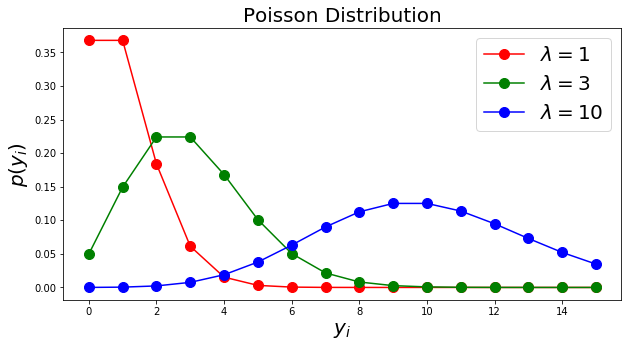

In [10]:
from scipy.stats import poisson
fig, ax = plt.subplots(figsize=(10,5))
y = np.asarray(range(0, 16))
p1 = poisson.pmf(y, mu=1.)
p3 = poisson.pmf(y, mu=3.)
p10 = poisson.pmf(y, mu=10.)

ax.plot(y, p1, 'r.-', markersize=20, label='$\lambda=1$')
ax.plot(y, p3, 'g.-', markersize=20, label='$\lambda=3$')
ax.plot(y, p10, 'b.-', markersize=20, label='$\lambda=10$')
ax.set_title('Poisson Distribution', fontsize=20)
ax.set_xlabel('$y_i$', fontsize=20)
ax.set_ylabel('$p(y_i)$', fontsize=20)
ax.legend(fontsize=20)
plt.savefig('./diagrams/poisson.svg')


### Poisson Regression  (<span style="color:red">*optional*</span>)

* Poisson regression make rate a function of space/time.$$\log \lambda(\mathbf{x}, t) = \mathbf{w}_x^\top \boldsymbol{\phi_x(\mathbf{x})} + \mathbf{w}_t^\top \boldsymbol(\phi_t(t))$$

* This is known as a *log linear* or *log additive* model. 

* The link function is a logarithm.

* We can rewrite such a function as 
$$\log \lambda(\mathbf{x}, t) = f_x(\mathbf{x}) + f_t(t)$$

### Multiplicative Model  (<span style="color:red">*optional*</span>)

* Be careful though ... a log additive model is really multiplicative.
$$\log \lambda(\mathbf{x}, t) = f_x(\mathbf{x}) + f_t(t)$$

* Becomes $$\lambda(\mathbf{x}, t) = \exp(f_x(\mathbf{x}) + f_t(t))$$

* Which is equivalent to  $$\lambda(\mathbf{x}, t) = \exp(f_x(\mathbf{x}))\exp(f_t(t))$$

* Link functions can be deceptive in this way.

#### Reading

- Section 5.2.2 of @Rogers:book11 up to pg 182.
